In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1" 

In [2]:
import os
import sys
from os.path import abspath, expanduser
sys.path.append(abspath(expanduser("/../..")))
import unittest
from sequence_annotation.processor.compiler.keras import SimpleCompiler,AnnSeqCompiler
from sequence_annotation.model.model_processor import SimpleModel,ModelCreator,IModelProcessor
from sequence_annotation.processor.data_processor import AnnSeqData,SimpleData
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation,Input
from sequence_annotation.processor.worker.train_worker import TrainWorker
from sequence_annotation.processor.worker.test_worker import TestWorker
from sequence_annotation.pipeline.pipeline import Pipeline
from sequence_annotation.model.customize import MaskedConvolution1D,RemoveMask,noised_relu
from sequence_annotation.genome_handler.seq_container import AnnSeqContainer
from sequence_annotation.genome_handler.ann_seq_processor import class_count
from sequence_annotation.data_handler.fasta import read_fasta
from sequence_annotation.data_handler.json import read_json
from sequence_annotation.data_handler.seq_converter import SeqConverter
from sequence_annotation.pipeline.wrapper import fit_generator_wrapper_generator,fit_wrapper_generator
from sequence_annotation.pipeline.wrapper import evaluate_generator_wrapper_generator
from sequence_annotation.pipeline.callback import AdvancedModelCheckpoint,ResultHistory,ModelPlot
from sequence_annotation.processor.metric.metric import BatchCount,TruePositive,SampleCount,Accuracy
from sequence_annotation.processor.metric.metric_builder import MetricBuilder
from sequence_annotation.processor.metric.stateful_metric import StatefulMetric
from keras.callbacks import TensorBoard 
import numpy as np
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from hyperopt import Trials, STATUS_OK, tpe
import random
from sequence_annotation.genome_handler.sequence import AnnSequence
from sequence_annotation.genome_handler.seq_container import AnnSeqContainer
from sequence_annotation.pipeline.data_generator import DataGenerator
from keras.layers import BatchNormalization, ReLU, Conv1D, Add, Dropout, Concatenate,Layer,LSTM,Bidirectional
from keras.layers import RNN,Masking,SimpleRNNCell,CuDNNGRU
from tensorflow.contrib.cudnn_rnn import CudnnCompatibleGRUCell
from keras.engine.training import Model
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
if hasattr(config,"gpu_options"):
    config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [4]:
import deepdish as dd
h5=dd.io.load('../io/data/2018_11_24/Araport11_exon_2018_11_24_merged_with_coordinate_file_megred_exon_dist_to_five_1000_dist_to_three_500_merged.h5')
fasta = read_fasta('../io/data/2018_11_24/Araport11_exon_2018_11_24_merged_with_coordinate_file_megred_exon_dist_to_five_1000_dist_to_three_500_merged.fasta')
ann_seqs = AnnSeqContainer().from_dict(h5)
from numpy import median
median_len = median([len(seq) for seq in ann_seqs])
median_fasta = {}
for seq in ann_seqs:
    if len(seq)<= median_len:
        median_fasta[seq.id]=fasta[seq.id]
keys = list(median_fasta.keys())
random.shuffle(keys)
selected_seqs = AnnSeqContainer()
selected_seqs.ANN_TYPES = ann_seqs.ANN_TYPES
selected_fasta = {}
number = 0
for seq_id in keys:
    selected_seqs.add(ann_seqs.get(seq_id))
    selected_fasta[seq_id]=median_fasta[seq_id]
    number += 1
    if number >= int(10):
        break

In [5]:
class IRNNCell(Layer):
    def __init__(self, units,relu_noise_cooef, **kwargs):
        self.units = units
        self.state_size = units
        self._relu_noise_cooef = relu_noise_cooef
        super().__init__(**kwargs)
    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        config['relu_noise_cooef']= self._relu_noise_cooef
        return config
    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='random_uniform',
                                      name='kernel')
        self.bias = self.add_weight(shape=(1,self.units),
                                      initializer='zeros',
                                      name='bias')
        self.activation =  noised_relu
        self.built = True
    def call(self, inputs, states):
        prev_output = states[0]
        inputs_ = K.dot(inputs, self.kernel)
        output = self.activation(inputs_ + prev_output+self.bias,c=self._relu_noise_cooef)
        return output, [output]

In [6]:
from keras.layers import Activation

import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
import keras
from keras.utils.generic_utils import CustomObjectScope
from keras.utils import multi_gpu_model

class SeqAnnModelBuilder(IModelProcessor):
    def __init__(self,input_dim,output_dim,cnn_kernel_size=2,cnn_unit=2,cnn_layer=2,
                 rnn_unit=2,rnn_layer=2,softmax_unit=2,relu_noise_cooef=0):
        self._record = {'input_dim':input_dim,
                        'output_dim':output_dim,
                        'cnn_kernel_size':cnn_kernel_size,
                        'cnn_unit':cnn_unit,
                        'cnn_layer':cnn_layer,
                        'rnn_unit':rnn_unit,
                        'rnn_layer':rnn_layer,
                        'softmax_unit':softmax_unit,
                        'relu_noise_cooef':relu_noise_cooef}
    def process(self):
        input_dim = self._record['input_dim']
        output_dim = self._record['output_dim']
        inputs = Input(shape=(None,input_dim),name='Input')
        inputs_ = Masking(mask_value=0,name='mask')(inputs)
        previous_layer = inputs_
        previous_input = inputs_
        cnn_number = self._record['cnn_layer']
        rnn_number = self._record['rnn_layer']
        cnn_kernel_size = self._record['cnn_kernel_size']
        cnn_unit = self._record['cnn_unit']
        rnn_unit = self._record['rnn_unit']
        softmax_unit = self._record['softmax_unit']
        relu_noise_cooef = self._record['relu_noise_cooef']
        for index in range(cnn_number):
            if previous_layer!=previous_input:
                input_ = Concatenate(name='CNN_concat_'+str(index))([previous_input,previous_layer])
            else:
                input_ = previous_input
            cnn = MaskedConvolution1D(cnn_unit,kernel_size=cnn_kernel_size,
                                      activation='relu',padding='same',
                                      name='cnn_'+str(index))(input_)
            bn = BatchNormalization()(cnn)
            previous_input = input_
            previous_layer = bn
        if softmax_unit is not None:
            softmax = MaskedConvolution1D(softmax_unit,kernel_size=1,
                                          activation='softmax',padding='same',
                                          name='softmax')(previous_input)
        
            previous_input = softmax
            previous_layer = softmax
        for index in range(rnn_number):
            if previous_layer!=previous_input:
                input_ = Concatenate(name='RNN_concat_'+str(index))([previous_input,previous_layer])
            else:
                input_ = previous_input
            with CustomObjectScope({'IRNNCell' : IRNNCell}):
                rnn_ = RNN(IRNNCell(rnn_unit,relu_noise_cooef=relu_noise_cooef),
                           return_sequences=True,name='rnn_'+str(index))
                rnn = Bidirectional(rnn_,name='bidir_rnn_'+str(index))(input_)
                if index < (rnn_number-1):
                    bn = BatchNormalization()(rnn)
                    previous_layer = bn
                else:
                    previous_layer = rnn
                previous_input = input_
        cnn = MaskedConvolution1D(output_dim,kernel_size=1,activation='softmax',
                                  name='predict',padding='same')(previous_layer)
        outputs = RemoveMask()(cnn)
        self._model = Model(inputs=inputs, outputs=outputs)
    @property
    def model(self):
        return self._model
    @property
    def record(self):
        return self._record


In [7]:
class ModelOptimizer:
    def __init__(self):
        self.x_train, self.y_train, self.x_test, self.y_test=self._prepare_data()
        self.record = []
        self._id=1
    def _prepare_data(self):
        data = AnnSeqData({'data':{'training':{'inputs':selected_fasta,
                                               'answers':selected_seqs}
                                  },'ANN_TYPES':selected_seqs.ANN_TYPES},
                          discard_invalid_seq=True,validation_split=0.5,
                          do_validate=True,padding_value=0

                         )
        data.before_process()
        data.process()
        data.after_process()
        return (data.data['training']['inputs'],
                data.data['training']['answers'],
                data.data['validation']['inputs'],
                data.data['validation']['answers'])
    def _create_model(self,space):
        builder = SeqAnnModelBuilder(**space)
        builder.process()
        simple_model = SimpleModel(builder.model)
        return simple_model
    def get_loss(self,space):
        print(space)
        model = self._create_model(space)
        compiler = SimpleCompiler('adam','categorical_crossentropy',metrics=[Accuracy(values_to_ignore=0)])
        data = SimpleData({'training':{'inputs':self.x_train,'answers':self.y_train},
                          'validation':{'inputs':self.x_test,'answers':self.y_test}})
        worker = TrainWorker(is_verbose_visible=True)
        callbacks = [ModelPlot('2018_12_09/model_'+str(self._id)+'.png',
                        show_shapes =True,
                        show_layer_names =True),
                     ResultHistory('2018_12_09/result_'+str(self._id)+'.csv',period=1,verbose=True)]
        wrapper = fit_generator_wrapper_generator(verbose=1,batch_size=40,epochs=25,
                                                 callbacks=callbacks)
        pipeline = Pipeline(model,data,compiler,worker,
                            wrapper,is_prompt_visible=True)

        pipeline.execute()
        #get the highest validation accuracy of the training epochs
        val_acc = np.amax(worker.result['val_categorical_accuracy']) 
        #self._loss = -validation_acc
        self._id += 1
        print('Best validation accuracy of epoch:', val_acc)
        self.record.append({'metric':worker.result,'space':space})
        return {'loss': -val_acc, 'status': STATUS_OK,'space':space}

In [ ]:
modelOptimizer2 = ModelOptimizer()
trials2 = Trials()

In [8]:
from hyperopt import Trials, STATUS_OK, tpe,fmin, tpe,hp
import pickle
space2 = {'input_dim':4,
         'output_dim':4, 
         'cnn_kernel_size':120, 
         'cnn_unit':4,#hp.randint('cnn_unit',4)+1, 
         'cnn_layer':8,#hp.randint('cnn_layer',33), 
         'rnn_unit':110,
         'rnn_layer':4,
         'relu_noise_cooef':0#hp.uniform('relu_noise_cooef',0,1)
         }
#best = fmin(modelOptimizer2.get_loss, space=space2,algo=tpe.suggest ,trials=trials2, max_evals=32)

In [60]:
best

{'rnn_unit': 107}

In [ ]:
pickle.dump(trials2, open("2018_12_09/trails.p", "wb"))

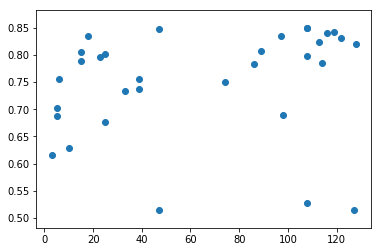

In [59]:
import matplotlib.pyplot as pyplt
pyplt.scatter([r['space']['rnn_unit'] for r in trials2.results],
              [-r['loss'] for r in trials2.results])

In [11]:
from keras import optimizers
from keras.optimizers import Adam

builder = SeqAnnModelBuilder(4,4,cnn_layer=0,rnn_layer=0,softmax_unit=None)
compiler = AnnSeqCompiler(Adam(lr=1e-2),'categorical_crossentropy',
                          dynamic_weight_method=None,
                          ann_types=selected_seqs.ANN_TYPES,values_to_ignore=0,
                          metrics=[Accuracy(name='acc',values_to_ignore=0)])
data = AnnSeqData({'data':{'training':{'inputs':selected_fasta,
                                       'answers':selected_seqs}
                          },'ANN_TYPES':selected_seqs.ANN_TYPES},
                  discard_invalid_seq=True,validation_split=0.5,
                  do_validate=True,padding_value=0
              
                 )
worker = TrainWorker(is_verbose_visible=True)
callbacks = [ModelPlot('2018_11_29/model.png',
                        show_shapes =True,
                        show_layer_names =True),
             TensorBoard('../io/logs/',write_graph=True, write_grads=True, write_images=True),
             ResultHistory('2018_11_29/result.csv',period=3,verbose=True),
             AdvancedModelCheckpoint('2018_11_29/weights/weights_{epoch:04d}.hdf5',period=1)]
wrapper = fit_generator_wrapper_generator(verbose=1,batch_size=5,
                                          epochs=1000,epoch_shuffle=True,callbacks=[])
worker.wrapper=wrapper
pipeline = Pipeline(builder,data,compiler,worker)

pipeline.execute()

Processing data...
Processing model..
Compiling model...
Processing worker...
Executing...
Start working(2018-12-15 09:15:52)
Epoch 1/1000
1/1 [==============================] - 0s 371ms/step - loss: 1.5048 - acc: 0.1650 - exon_FN: 4205.0000 - mix_FN: 0.0000e+00 - intron_FN: 915.0000 - exon_TP: 1215.0000 - intron_FP: 6306.0000 - categorical_accuracy: 0.1650 - intron_TP: 1279.0000 - other_TN: 7614.0000 - other_TP: 0.0000e+00 - other_FP: 0.0000e+00 - mix_TN: 10445.0000 - exon_TN: 8049.0000 - mix_FP: 4669.0000 - exon_FP: 1645.0000 - mix_TP: 0.0000e+00 - other_FN: 7500.0000 - intron_TN: 6614.0000 - val_loss: 1.4964 - val_acc: 0.1230 - val_exon_FN: 2576.0000 - val_mix_FN: 0.0000e+00 - val_intron_FN: 696.0000 - val_exon_TP: 718.0000 - val_intron_FP: 5345.0000 - val_categorical_accuracy: 0.1230 - val_intron_TP: 793.0000 - val_other_TN: 4783.0000 - val_other_TP: 0.0000e+00 - val_other_FP: 0.0000e+00 - val_mix_TN: 8375.0000 - val_exon_TN: 7470.0000 - val_mix_FP: 3908.0000 - val_exon_FP: 1519.00

Epoch 10/1000
1/1 [==============================] - 0s 92ms/step - loss: 1.3759 - acc: 0.1650 - exon_FN: 4205.0000 - mix_FN: 0.0000e+00 - intron_FN: 915.0000 - exon_TP: 1215.0000 - intron_FP: 6306.0000 - categorical_accuracy: 0.1650 - intron_TP: 1279.0000 - other_TN: 7614.0000 - other_TP: 0.0000e+00 - other_FP: 0.0000e+00 - mix_TN: 10445.0000 - exon_TN: 8049.0000 - mix_FP: 4669.0000 - exon_FP: 1645.0000 - mix_TP: 0.0000e+00 - other_FN: 7500.0000 - intron_TN: 6614.0000 - val_loss: 1.3548 - val_acc: 0.3255 - val_exon_FN: 2576.0000 - val_mix_FN: 0.0000e+00 - val_intron_FN: 696.0000 - val_exon_TP: 718.0000 - val_intron_FP: 5345.0000 - val_categorical_accuracy: 0.3255 - val_intron_TP: 793.0000 - val_other_TN: 3362.0000 - val_other_TP: 2487.0000 - val_other_FP: 1421.0000 - val_mix_TN: 12283.0000 - val_exon_TN: 7470.0000 - val_mix_FP: 0.0000e+00 - val_exon_FP: 1519.0000 - val_mix_TP: 0.0000e+00 - val_other_FN: 5013.0000 - val_intron_TN: 5449.0000
Epoch 11/1000
1/1 [==========================

Epoch 19/1000
1/1 [==============================] - 0s 93ms/step - loss: 1.2674 - acc: 0.4917 - exon_FN: 4205.0000 - mix_FN: 0.0000e+00 - intron_FN: 2194.0000 - exon_TP: 1215.0000 - intron_FP: 0.0000e+00 - categorical_accuracy: 0.4917 - intron_TP: 0.0000e+00 - other_TN: 1577.0000 - other_TP: 6217.0000 - other_FP: 6037.0000 - mix_TN: 15114.0000 - exon_TN: 8049.0000 - mix_FP: 0.0000e+00 - exon_FP: 1645.0000 - mix_TP: 0.0000e+00 - other_FN: 1283.0000 - intron_TN: 12920.0000 - val_loss: 1.2381 - val_acc: 0.5677 - val_exon_FN: 2576.0000 - val_mix_FN: 0.0000e+00 - val_intron_FN: 1489.0000 - val_exon_TP: 718.0000 - val_intron_FP: 0.0000e+00 - val_categorical_accuracy: 0.5677 - val_intron_TP: 0.0000e+00 - val_other_TN: 992.0000 - val_other_TP: 6255.0000 - val_other_FP: 3791.0000 - val_mix_TN: 12283.0000 - val_exon_TN: 7470.0000 - val_mix_FP: 0.0000e+00 - val_exon_FP: 1519.0000 - val_mix_TP: 0.0000e+00 - val_other_FN: 1245.0000 - val_intron_TN: 10794.0000
Epoch 20/1000
1/1 [===================

KeyboardInterrupt: 

In [22]:
class CudnnRNNRelu(Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super().__init__(**kwargs)
    def get_config(self):
        config = super().get_config()
        config['units'] = self.units
        return config
    def build(self, input_shape):
        self.kernel = CudnnCompatibleGRUCell(shape=(input_shape[-1], self.units),
                                      initializer='random_uniform',
                                      name='kernel')
        self.bias = self.add_weight(shape=(1,self.units),
                                      initializer='zeros',
                                      name='bias')
        self.activation =  ReLU()#noised_relu
        self.built = True
    def call(self, inputs, states):
        prev_output = states[0]
        inputs_ = K.dot(inputs, self.kernel)
        output = self.activation(inputs_ + prev_output+self.bias)
        return output, [output]